# MScFE 622 Stochastic Modeling

### Group Work Project # 1

#### *Student Group 4209*

In [1]:
# Imporrt necessary libraries.
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brute, fmin
from scipy.integrate import quad

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def Heston_method(S0, v0, kappa_v, theta_v, sigma_v, T, M, Ite,r):
    dt = T / M  # T = maturity, M = number of time steps
    def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
        
        v = np.zeros((M + 1, Ite), dtype=float)
        v[0] = v0
        sdt = np.sqrt(dt)  # Sqrt of dt
        for t in range(1, M + 1):
            ran = np.dot(cho_matrix, rand[:, t])
            v[t] = np.maximum(
                0,
                v[t - 1]
                + kappa * (theta - v[t - 1]) * dt
                + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
            )
        return v

    def Heston_paths(S0, r, v, row, cho_matrix):
        S = np.zeros((M + 1, Ite), dtype=float)
        S[0] = S0
        sdt = np.sqrt(dt)
        for t in range(1, M + 1, 1):
            ran = np.dot(cho_matrix, rand[:, t])
            S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

        return S

    def random_number_gen(M, Ite):
        rand = np.random.standard_normal((2, M + 1, Ite))
        return rand

    # Covariance Matrix
    def cholesky(rho):
        covariance_matrix = np.zeros((2, 2), dtype=float)
        covariance_matrix[0] = [1.0, rho]
        covariance_matrix[1] = [rho, 1.0]
        cho_matrix = np.linalg.cholesky(covariance_matrix)
        return cho_matrix
    
    # Generating random numbers from standard normal
    rand = random_number_gen(M, Ite)
    
    # Cholesky matrix
    cho_matrix = cholesky(rho)
    
    # Volatility process paths
    V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

    # Underlying price process paths
    S = Heston_paths(S0, r, V, 0, cho_matrix)
    
    return S


In [18]:
# Heston Model input parameters
v0 = 0.1033
kappa_v = 3.0476
sigma_v = 4.7795e-06
theta_v = 0.1248
rho = 0.6155


S0 = 232.9  # Current underlying asset price
K = 232.9  # strike price
r = 0.015  # Risk-free rate
M0 = 252  # Number of time steps in a year
T = 20/250  # Number of years
t=0
M = int(M0 * T)  # Total time steps




In [19]:
def Asian_call(S, K, r, T, t):
    payoff = np.maximum(0, np.mean(S, axis=1) - K)

    average = np.mean(payoff)

    return np.exp(-r * (T - t)) * average

Number of Monte-carlo simulations

In [20]:
asian_call_price_array = []
iterations = list(range(5000,200000,5000))
for ite in iterations:
    heston_paths = Heston_method(S0, v0, kappa_v, theta_v, sigma_v, T, M, ite, r)
    asian_call_price_array.append(Asian_call(heston_paths, K, r, T, t))
    
mean_price = sum(asian_call_price_array)/len(asian_call_price_array)

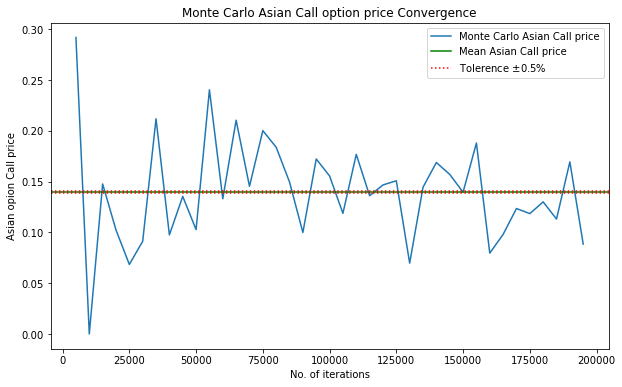

In [21]:
fig, ax1 = plt.subplots(figsize = (10,6))

#ax1.subplot(1,1,1)
ax1.plot(iterations, asian_call_price_array, label = 'Monte Carlo Asian Call price')
ax1.set(title='Monte Carlo Asian Call option price Convergence', ylabel='Asian opion Call price', xlabel='No. of iterations')
ax1.axhline(mean_price, c='g', label='Mean Asian Call price')
ax1.axhline(mean_price*1.005, c='r', linestyle='dotted', label='Tolerence $\pm$0.5%')
ax1.axhline(mean_price/1.005, c='r', linestyle='dotted')
ax1.legend();


In [22]:
Ite = 500000  # Number of simulations
heston_paths = Heston_method(S0, v0, kappa_v, theta_v, sigma_v, T, M, Ite, r)

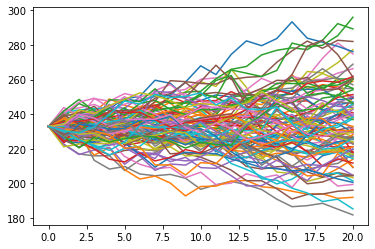

In [23]:
plt.plot(heston_paths[:,:100]);

In [24]:
asian_call_price = Asian_call(heston_paths, K, r, T, t)
print("Price of Asian Call is: ",asian_call_price.round(2))

Price of Asian Call is:  0.15


In [25]:
final_price = asian_call_price*1.04
print("Final price of Asian call option that client will end up paying: ",final_price.round(2))

Final price of Asian call option that client will end up paying:  0.15


## Heston Model

In [7]:
class Heston_model():
    # iteration for error function
    ite = 0
    def H93_char_func(self,u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
        """Valuation of European call option in H93 model via Lewis (2001)
        Fourier-based approach: characteristic function.
        Parameter definitions see function BCC_call_value."""
        c1 = kappa_v * theta_v
        c2 = -np.sqrt(
            (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
        )
        c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
            kappa_v - rho * sigma_v * u * 1j - c2
        )
        H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
            (kappa_v - rho * sigma_v * u * 1j + c2) * T
            - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
        )
        H2 = (
            (kappa_v - rho * sigma_v * u * 1j + c2)
            / sigma_v**2
            * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
        )
        char_func_value = np.exp(H1 + H2 * v0)
        return char_func_value

    def H93_int_func(self,u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
        """
        Fourier-based approach for Lewis (2001): Integration function.
        """
        char_func_value = self.H93_char_func(
            u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
        )
        int_func_value = (
            1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
        )
        return int_func_value
    
    
    def H93_call_value(self, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
        """Valuation of European call option in H93 model via Lewis (2001)

        Parameter definition:
        ==========
        S0: float
            initial stock/index level
        K: float
            strike price
        T: float
            time-to-maturity (for t=0)
        r: float
            constant risk-free short rate
        kappa_v: float
            mean-reversion factor
        theta_v: float
            long-run mean of variance
        sigma_v: float
            volatility of variance
        rho: float
            correlation between variance and stock/index level
        v0: float
            initial level of variance
        Returns
        =======
        call_value: float
            present value of European call option
        """
        int_value = quad(
            lambda u: self.H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
            0,
            np.inf,
            limit=250,
        )[0]
        call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
        return call_value

    
    def H93_error_function(self,p0):
        """Error function for parameter calibration via
        Lewis (2001) Fourier approach for Heston (1993).
        Parameters
        ==========
        kappa_v: float
            mean-reversion factor
        theta_v: float
            long-run mean of variance
        sigma_v: float
            volatility of variance
        rho: float
            correlation between variance and stock/index level
        v0: float
            initial, instantaneous variance
        Returns
        =======
        MSE: float
            mean squared error
        """
        min_MSE = 500
        kappa_v, theta_v, sigma_v, rho, v0 = p0
        if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
            return min_MSE
        if 2 * kappa_v * theta_v < sigma_v**2:
            return min_MSE
        se = []
        for row, option in options.iterrows():
            model_value = self.H93_call_value(
                S0,
                option["Strike"],
                option["T"],
                option["r"],
                kappa_v,
                theta_v,
                sigma_v,
                rho,
                v0,
            )
            se.append((model_value - option["Call"]) ** 2)
        MSE = sum(se) / len(se)
        #min_MSE = min(min_MSE, MSE)
        if Heston_model.ite % 25 == 0:
            print("%4d |" % Heston_model.ite, np.array(p0), "| %7.3f" % (MSE))
        Heston_model.ite += 1
        return MSE
    

    def H93_calibration_full(self):
        """Calibrates Heston (1993) stochastic volatility model to market quotes."""
        # First run with brute force
        # (scan sensible regions, for faster convergence)
        p0 = brute(
            self.H93_error_function,
            (
                (2.5, 10.6, 5.0),  # kappa_v
                (0.01, 0.041, 0.01),  # theta_v
                (0.05, 0.251, 0.1),  # sigma_v
                (-0.75, 0.01, 0.25),  # rho
                (0.01, 0.031, 0.01),
            ),  # v0
            finish=None,
        )

        # Second run with local, convex minimization
        # (we dig deeper where promising results)
        opt = fmin(
            self.H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
        )
        return opt

In [8]:
Heston_model().H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)

NameError: name 'K' is not defined

In [9]:
Heston_model().H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] | 820.892
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  23.864
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  89.655
  75 | [ 2.5   0.03  0.15 -0.5   0.01] | 193.283
 100 | [ 2.5   0.04  0.05 -0.5   0.02] | 176.340
 125 | [ 2.5   0.04  0.25 -0.5   0.03] | 486.965
 150 | [ 7.5   0.01  0.15 -0.25  0.01] | 840.337
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  24.810
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  24.834
 225 | [7.5  0.03 0.15 0.   0.01] | 110.936
 250 | [7.5  0.04 0.05 0.   0.02] | 540.183
 275 | [7.5  0.04 0.25 0.   0.03] | 783.222
 300 | [ 2.61379559  0.00992657  0.15610448 -0.76361614  0.02778356] |   8.046
 325 | [ 1.9152359   0.01257942  0.16036675 -0.91693167  0.0248233 ] |   6.301
 350 | [ 2.04831069  0.01215428  0.15832201 -0.89057611  0.02532865] |   6.151
 375 | [ 2.0376908   0.01207312  0.16816435 -0.86785979  0.02553311] |   6.097
 400 | [ 1.97316132  0.01247835  0.2032535  -0.83478704  0.0254568 ] |   6.002
 425 | [ 2.07617861  0.01268556 

array([ 5.04735825,  0.01872573,  0.43477689, -0.44795621,  0.02728912])

In [3]:
# Market Data from www.eurexchange.com
# as of September 30, 2014

h5 = pd.HDFStore(
    "option_data_wqu.h5", "r"
)  # Place this file in the same directory before running the code
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level September 30, 2014

In [4]:
# Option Selection
tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

In [5]:
# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.02

In [6]:
options.head()

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.02
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.02
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.02
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.02
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.02


In [18]:
data.head()

,Date,Strike,Call,Maturity,Put
0,1412035200000000000,1850.0,1373.6,1418947200000000000,0.5
1,1412035200000000000,1900.0,1323.7,1418947200000000000,0.6
2,1412035200000000000,1950.0,1273.8,1418947200000000000,0.8
3,1412035200000000000,2000.0,1223.9,1418947200000000000,0.9
4,1412035200000000000,2050.0,1174.1,1418947200000000000,1.1


In [2]:
#importing market data

# Given 
S0 = 232.9
r=1.5/100

options = pd.read_excel("MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx" )
options["T"] = options["Days to maturity"]/250.0

In [6]:
options.head()

,Days to maturity,Strike,Price,Type,T
0,15,227.5,10.52,C,0.06
1,15,230.0,10.05,C,0.06
2,15,232.5,7.75,C,0.06
3,15,235.0,6.01,C,0.06
4,15,237.5,4.75,C,0.06


In [16]:
# Required: Call options data with 15 days maturity
call_15 = options[(options["Days to maturity"]==15) & (options["Type"]=='C')]
call_15.head()



,Days to maturity,Strike,Price,Type,T
0,15,227.5,10.52,C,0.06
1,15,230.0,10.05,C,0.06
2,15,232.5,7.75,C,0.06
3,15,235.0,6.01,C,0.06
4,15,237.5,4.75,C,0.06


In [8]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of Asian call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function."""

    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value


def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value



In [ ]:
i = 0
min_MSE = 500

def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE, opt
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options1.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append(abs((model_value - option["Price"])/option["Price"]))
    MSE = sum(se)* np.sqrt(np.sum((p0 - opt) ** 2)) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
                (10, 22, 3.0),  # kappa_v
                (0.01, 0.1, 0.01),  # theta_v
                (0.05, 0.3, 0.05),  # sigma_v
                (-0.9, 0.75, 0.25),  # rho
                (0.01, 0.2, 0.03),
            ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=2500, maxfun=2500
    )
    return opt

In [ ]:
opt = H93_calibration_full()

In [ ]:
H93_values = []
kappa_v, theta_v, sigma_v, rho, v0 = opt
for row, option in options1.iterrows():
        H93_values.append( H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        )

In [ ]:
plt.plot(options1.Strike, options1.Price, "b", label="market")
plt.plot(options1.Strike, H93_values, "ro", label="model")

### Bates

So, this is the parameters resulting from calibration of the Heston (1993) model:

- $\kappa_\nu = 18.447$
- $\theta_\nu = 0.026$
- $\sigma_\nu = 0.978$
- $\rho = -0.8218$
- $\nu_0 = 0.035$

\
We will now use these parameters to calibrate the jump component of the model.


## 2. Calibrate jump component in Bates (1996)

After we have run the first calibration process for the basic Heston (1993) model, we will take the parameters obtained and used them to calibrate the jump component in Bates (1996). For this task, first thing we need is to obtain option market data. As we have done so many times before, let's use our sample data from EuroStoxx 50 index equity options.


## 2.1. Getting options market data

This process is virtually the same we have done for loading options market data many times before:

\
First, we load option market data from the file `option_data_wqu.h5`:

In [ ]:
# Option market data loading
h5 = pd.HDFStore("option_data_M2.h5", "r")
data = h5["data"]  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014

In [ ]:
# Set tolerance level for near ATM options
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

In [ ]:
# Adding Time-to-Maturity and constant short-rates
for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.02

In [ ]:
# Select closest maturity
mats = sorted(set(options["Maturity"]))
options = options[options["Maturity"] == mats[0]]

In [ ]:
time_to_mat = options["Maturity"].iloc[0] - options["Date"].iloc[0]
time_to_mat

In [ ]:
options.head(5)

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

In [ ]:
def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

In [ ]:
def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

In [ ]:
params = B96_calibration_short()

In [ ]:
params

lamb = 0
mu = -0.5
delta = 0

### 2.4.4. Model vs. Market prices after jump calibration

Now, let's see how our model prices fit the observed market prices after this 2 step calibration process.

\
For that, we first create a function that yields the model values under the different parameters obtained in the calibration process:

In [ ]:
def B96_jump_calculate_model_values(p0):
    """Calculates all model values given parameter vector p0."""
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (option["Maturity"] - option["Date"]).days / 365.0
        r = 0.02
        model_value = B96_call_value(
            S0,
            option["Strike"],
            T,
            r,
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        values.append(model_value)
    return np.array(values)

In [ ]:
def plot_calibration_results(p0):
    options["Model"] = B96_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_calibration_results(params)


## 3. Full Bates (1996) model calibration

For the final step of this lengthy calibration process, we can repeat the process of using the previously calibrated values as inputs for the full calibration of the model. 

In this case, our inputs will not only consist on the parameters from the stochastic volatility model ($\kappa_\nu$, $\theta_\nu$, $\sigma_\nu$, $\rho$, $\nu_0$), but also those from the jump component ($λ$, $\mu$, $\delta$).

Hence, our $p_0$ is defined as:

In [ ]:
p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
i = 0
min_MSE = 5000.0


def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )
        se.append((model_value - option["Call"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
def B96_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        model_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        values.append(model_value)

    return np.array(values)

In [ ]:
full_params = B96_calibration_full()

In [ ]:
full_params

Which basically yields (note that these would slightly change upon small twitches of the code):

- $\kappa_\nu = 18.858$
- $\theta_\nu = 0.0249$
- $\sigma_\nu = 0.961$
- $\rho = -0.917$
- $\nu_0 = 0.0327$
- $\lambda = 0.000$
- $\mu = -0.508$
- $\delta = 0.001$


## 3.2. Market vs. Model prices in full calibration 

As before, let's see what are the differences that our model produces using the parameters resulting from calibration, and compare those to observed market prices:

In [ ]:
def plot_full_calibration_results(p0):
    options["Model"] = B96_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Maturity %s" % str(options["Maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Call, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(options.Call) - 10,
            max(options.Call) + 10,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

In [ ]:
plot_full_calibration_results(full_params)